In [3]:
library(tidyverse)
library(dbplyr)
library(DBI)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
set.seed(2000)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


Attaching package: ‘dbplyr’


The following objects are masked from ‘package:dplyr’:

    ident, sql


── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ rec

In [4]:
## load data
player_stat = read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# clean data
# change column names from space sperated to underscore seperated
colnames(player_stat) = gsub(" ", "_", colnames(player_stat))

# seperate "Age" into age and date of birth,
# "Current_Rank" into current rank and points,
# "Best_Rank" into best rank and date of best rank.
player_clean <- player_stat |>
separate(col = Age, into = c("Age", "Date_Of_Birth"), sep = " ", convert = TRUE) |>
separate(col = Current_Rank, into = c("Current_Rank", "Points"), sep = " ", convert = TRUE) |>
separate(col = Best_Rank, into = c("Best_Rank", "Date_Of_Best_Rank"), sep = " ", convert = TRUE)

# clean Seasons from string into numeric
# remove characters in Pirze_Money, and change into double
player_clean$Seasons <- as.numeric(player_stat$Seasons)
player_clean$Prize_Money <- gsub("\\D+", "", as.character(player_clean$Prize_Money))
player_clean$Prize_Money <- as.numeric(player_clean$Prize_Money)

# player_data: select Age, Seasons, Current_Rank, Best_Rank, Prize_Money
player_data <- select(player_clean, Age, Seasons, Current_Rank, Best_Rank, Prize_Money)

head(player_data)

Age,Seasons,Current_Rank,Best_Rank,Prize_Money
<int>,<dbl>,<int>,<int>,<dbl>
26,NA,378,363,NA
18,NA,326,316,59040
32,14,178,44,3261567
21,2,236,130,374093
27,11,183,17,6091971
22,5,31,31,1517157


In [6]:
# numeric summary of predictor variables
# getting values for predictor variable table

# age values
age_mean <- mean(player_data$Age, na.rm = TRUE)
age_missing <- sum(is.na(player_data$Age))

# seasons values
seasons_mean <- mean(player_data$Seasons, na.rm = TRUE)
seasons_missing <- sum(is.na(player_data$Seasons))

# best rank values
best_rank_mean <- mean(player_data$Best_Rank, na.rm = TRUE)
best_rank_missing <- sum(is.na(player_data$Best_Rank))

# prize money values
prize_money_mean <- mean(player_data$Prize_Money, na.rm = TRUE)
prize_money_missing <- sum(is.na(player_data$Prize_Money))

total_row <- nrow(player_data)

*Table 1: Predictor variable characteristics determined using training data*
<div style="float: left">
    
| PREDICTOR VARIABLE | AGE   | SEASONS | BEST RANK | PRIZE MONEY |
|--------------------|-------|---------|-----------|-------------|
| MEAN               | 25.97 | 6.49    | 178.2     | 210         |
| NUMBER OF ROWS     | 500   | 500     | 500       | 500         |
| MISSING ROWS       | 1     | 126     | 1         | 81          |

</div>


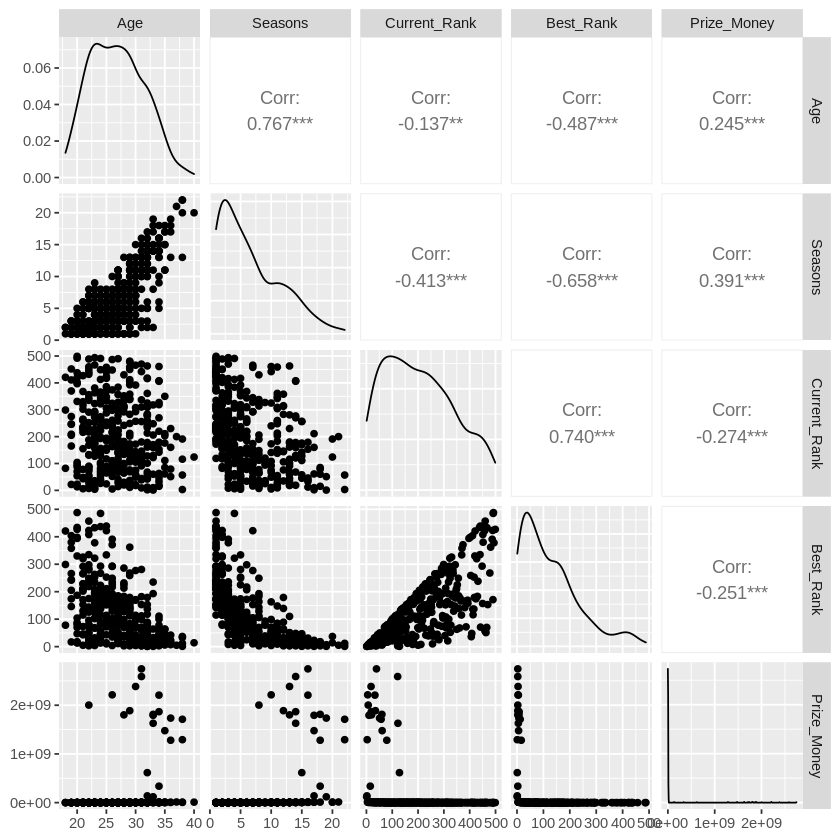

In [11]:
# visualization

# remove all rows with empty variables
player_data <- player_data |>
    na.omit()
player_data_plot <- player_data |>
                ggpairs()

player_data_plot

In [12]:
# split data into train and test with a proportion of 75% 
# to ensure the accuraccy our model is not overrated
# Also shuffles and stratifies the data by the variable we are trying to predit, 

player_split <- initial_split(player_data, prop = 0.75, strata = Current_Rank)
player_train <- training(player_split)
player_test <- testing(player_split)

In [13]:
# recipe and model
player_recipe <- recipe(Current_Rank~Age+Seasons+Best_Rank+Prize_Money, data = player_train) |>
    step_scale(all_predictors()) |>
    step_scale(all_predictors())

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("regression")

# create a 5-fold cross-validation object, and put recipe and model specification together in a workflow
player_vfold <- vfold_cv(player_train, v = 5, strata = Current_Rank)

player_wkflw <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) 

In [14]:
# 5-fold cross-validation to choose the number of neighbors with min RMSPE

gridvals <- tibble(neighbors = seq(1, 200)) 

player_multi <- player_wkflw |>
    tune_grid(player_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "rmse") |>
    filter(mean == min(mean))

player_k <- player_multi |>
    pull(neighbors)

player_multi

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
14,rmse,standard,86.8451,5,5.425765,Preprocessor1_Model014


In [16]:
# from last step, we have smallest RMPSPE when k = 14
# re-train the mode with k = 14, and use the model to make prediction on the test data

player_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = player_k) |>
    set_engine("kknn") |>
    set_mode("regression")

knn_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(player_spec) |>
    fit(data = player_train)

knn_preds <- knn_fit |>
    predict(player_test) |>
    bind_cols(player_test)

knn_mets <- metrics(knn_preds, truth = Current_Rank, estimate = .pred) |>
    filter(.metric == "rmse")

knn_mets

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,68.48568
